# Preparação do Ambiente

## Instalação das bibliotecas

In [1]:
%%capture
!pip install bertopic tqdm scikit-learn numpy pandas umap-learn hdbscan plotly beautifulsoup4 nltk transformers torch nbformat gensim matplotlib

## Importação das bibliotecas
Após a instalação, tem que reiniciar a sessão.

In [1]:
import os
import re
import numpy as np
import random
import nltk
import torch
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Definição de Funções Úteis

## Calcula stopwords com TF-IDF

In [2]:
def gerar_stopwords_personalizadas(processed_docs, quantil=0.02, n_top=50, output_dir="."):
    """
    Gera uma lista de palavras com baixa relevância média de TF-IDF e salva como stopwords sugeridas.

    Parâmetros:
        processed_docs (List[str]): Lista de documentos pré-processados (strings).
        quantil (float): Percentual inferior de termos para extrair como stopwords (ex: 0.02 = 2%).
        n_top (int): Número de palavras menos relevantes a exibir no gráfico.
        output_dir (str): Caminho da pasta onde os arquivos serão salvos.

    Resultados:
        - Arquivo "stopwords_extras.txt" com as palavras sugeridas
        - Gráfico "palavras_menos_relevantes.png"
        - DataFrame com termos e TF-IDF médio (retornado)
    """
    # Cria vetor TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words=None,
        ngram_range=(1, 1)
    )
    tfidf_matrix = vectorizer.fit_transform(processed_docs)

    # Calcula TF-IDF médio por termo
    tfidf_mean = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    vocabulario = np.array(vectorizer.get_feature_names_out())
    df_tfidf = pd.DataFrame({"termo": vocabulario, "tfidf_medio": tfidf_mean})
    df_tfidf.sort_values(by="tfidf_medio", inplace=True)

    # Gráfico das palavras menos relevantes
    plt.figure(figsize=(12, 5))
    plt.bar(df_tfidf["termo"][:n_top], df_tfidf["tfidf_medio"][:n_top], color='gray')
    plt.xticks(rotation=90)
    plt.title(f"{n_top} palavras menos relevantes (menor média TF-IDF)", fontsize=14)
    plt.xlabel("Termos")
    plt.ylabel("Média TF-IDF")
    plt.tight_layout()
    path_grafico = f"{output_dir}/palavras_menos_relevantes.png"
    plt.savefig(path_grafico, dpi=300)
    plt.close()

    # Geração da lista de stopwords
    limite = int(len(df_tfidf) * quantil)
    stopwords_sugeridas = df_tfidf["termo"].head(limite).tolist()

    path_stopwords = f"{output_dir}/stopwords_extras.txt"
    with open(path_stopwords, "w", encoding="utf-8") as f:
        for palavra in stopwords_sugeridas:
            f.write(palavra + "\n")

    print(f"✅ {len(stopwords_sugeridas)} stopwords sugeridas salvas em '{path_stopwords}'")
    print(f"📊 Gráfico salvo em '{path_grafico}'")

    return df_tfidf


## Carrega stopwords customizadas

In [3]:
def load_custom_stopwords(file_path):
    with open(file_path, 'r') as file:
        custom_stopwords = [line.strip() for line in file]
    return custom_stopwords

## Carrega acórdãos

In [4]:
def load_acordaos_from_html(folder_path, qtde_documentos):
    ementas = []
    cont = 0
    for file in tqdm(os.listdir(folder_path), desc="Lendo ementas HTML"):
        if file.endswith(".html"):
            file_path = os.path.join(folder_path, file)
            with open(file_path, "r", encoding="utf-8") as f:
                soup = BeautifulSoup(f.read(), "html.parser")

                # Captura todos os <p data-estilo-editor="Ementa">
                paragrafos_ementa = soup.find_all("p", attrs={"data-estilo-editor": "Ementa"})

                # Extrai o texto limpo e junta os parágrafos em um único texto por acórdão
                texto_ementa = " ".join(p.get_text(strip=True) for p in paragrafos_ementa)

                if texto_ementa:  # só adiciona se não estiver vazio
                    ementas.append(texto_ementa)
        cont += 1
        if cont == qtde_documentos:
            break
    return ementas

'\n    acordaos = []\n    cont = 0\n    for file in tqdm(os.listdir(folder_path), desc="Lendo acórdãos HTML"):\n        if file.endswith(".html"):\n            with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:\n                soup = BeautifulSoup(f.read(), "html.parser")\n                for tag in soup(["script", "style"]):\n                    tag.decompose()\n                text = soup.get_text(separator=" ", strip=True)\n                acordaos.append(text)\n        cont += 1\n        if cont == qtde_documentos:\n            break\n    return acordaos\n'

## Pré-processamento

In [5]:
def preprocess(text):
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)
    tokens = word_tokenize(text.lower(), language="portuguese")

    tokens = [
        token
        for token in tokens
        if token not in stopwords_pt and len(token) > 2 and token.isalpha()
    ]

    return tokens

## Gera Embeddings

In [6]:
def generate_embeddings(texts, tokenizer, model):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Gerando embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            embeddings.append(mean_embedding)
    return np.array(embeddings)

# Execução do Modelo

## Define variáveis e parâmetros gerais

In [46]:
# Setup NLTK
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("rslp")

# Sementes globais
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

QTDE_ACORDAOS_PROCESSADOS = 2000

# Stopwords
stopwords_pt = set(stopwords.words("portuguese"))

# Caminho dos acórdãos
folder_path = "/content/acordaos"
raw_docs = load_acordaos_from_html(folder_path, QTDE_ACORDAOS_PROCESSADOS)
if not raw_docs:
    print("⚠️ Nenhum acórdão foi encontrado. Verifique o diretório.")
    exit()

# Pré-processa
# tokenized_docs: lista de tokens para cada documento
tokenized_docs = [preprocess(doc) for doc in tqdm(raw_docs, desc="Pré-processando")]

# processed_docs: une os tokens em strings para BERTopic
processed_docs = [" ".join(doc) for doc in tokenized_docs]

df_tfidf = gerar_stopwords_personalizadas(
    processed_docs=processed_docs,
    quantil=0.00,
    n_top=50,
    output_dir="."
)

file_path = '/content/stopwords_extras.txt'

stopwords_extras = load_custom_stopwords(file_path)
print(stopwords_extras)
stopwords_pt.update(stopwords_extras)

# Fixa o ramdom_state pra garantir reprodutibilidade
umap_model = UMAP(random_state=SEED)

dictionary = Dictionary(tokenized_docs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
Pré-processando: 100%|██████████| 1831/1831 [00:01<00:00, 1710.44it/s]


✅ 0 stopwords sugeridas salvas em './stopwords_extras.txt'
📊 Gráfico salvo em './palavras_menos_relevantes.png'
[]


## Pré-processamento

In [47]:
# Pré-processa
# tokenized_docs: lista de tokens para cada documento
tokenized_docs = [preprocess(doc) for doc in tqdm(raw_docs, desc="Pré-processando")]

# processed_docs: une os tokens em strings para BERTopic
processed_docs = [" ".join(doc) for doc in tokenized_docs]

if not processed_docs:
    print("❌ Todos os documentos estão vazios após o pré-processamento.")
    exit()


Pré-processando: 100%|██████████| 1831/1831 [00:01<00:00, 1730.38it/s]


## Gera Embeddings

In [48]:
# Carrega modelo LegalBERTpt_fp
model_name = "raquelsilveira/legalbertpt_fp"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Geração dos embeddings
embeddings = generate_embeddings(processed_docs, tokenizer, model)


Some weights of BertModel were not initialized from the model checkpoint at raquelsilveira/legalbertpt_fp and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Gerando embeddings: 100%|██████████| 1831/1831 [13:35<00:00,  2.24it/s]


## Define Modelo

### Padrão

In [63]:
# Modelagem de tópicos com BERTopic
melhor_min_topic_size = 10
melhor_modelo = BERTopic(
    embedding_model=None,
    language="portuguese",
    #vectorizer_model=CountVectorizer(ngram_range=(1, 1)),
    umap_model=umap_model
)

### Ngrama ampliado

In [65]:
# Modelagem de tópicos com BERTopic
melhor_min_topic_size = 10

# Vetorizador com ngrama ampliado
vectorizer_model = CountVectorizer(ngram_range=(1, 3))

melhor_modelo = BERTopic(
    embedding_model=None,
    language="portuguese",
    vectorizer_model=vectorizer_model,
    umap_model=umap_model
)

### Maior c_v

In [58]:
# Coerência c_v para diferentes min_topic_size
min_sizes = range(2, 52)
coerencias = []
melhor_score = -1
melhor_modelo = None
melhor_min_topic_size = None

for size in tqdm(min_sizes, desc="Avaliando coerência"):
    topic_model = BERTopic(
        embedding_model=None,
        language="portuguese",
        min_topic_size=size,
        umap_model=umap_model
    )
    topics, _ = topic_model.fit_transform(processed_docs, embeddings)
    top_n_words = [[word for word, _ in topic_model.get_topic(topic)]
                   for topic in topic_model.get_topics().keys()
                   if topic != -1 and topic_model.get_topic(topic)]
    cm = CoherenceModel(topics=top_n_words, texts=tokenized_docs,
                        dictionary=dictionary, coherence='c_v')
    score = cm.get_coherence()
    coerencias.append(score)
    print(f"min_topic_size = {size} → c_v = {score:.4f}")

    # Atualiza melhor modelo
    if score > melhor_score:
        melhor_score = score
        melhor_modelo = topic_model
        melhor_min_topic_size = size

# Mostra resultado final
print(f"\n✅ Melhor min_topic_size: {melhor_min_topic_size} com c_v = {melhor_score:.4f}")

# Salva o modelo
melhor_modelo.save("bertopic_model_melhor")

Avaliando coerência:   2%|▏         | 1/50 [00:20<17:05, 20.93s/it]

min_topic_size = 2 → c_v = 0.6959


Avaliando coerência:   4%|▍         | 2/50 [00:34<13:05, 16.37s/it]

min_topic_size = 3 → c_v = 0.7547


Avaliando coerência:   6%|▌         | 3/50 [00:47<11:40, 14.91s/it]

min_topic_size = 4 → c_v = 0.7501


Avaliando coerência:   8%|▊         | 4/50 [00:58<10:19, 13.47s/it]

min_topic_size = 5 → c_v = 0.7541


Avaliando coerência:  10%|█         | 5/50 [01:08<09:12, 12.28s/it]

min_topic_size = 6 → c_v = 0.7512


Avaliando coerência:  12%|█▏        | 6/50 [01:19<08:42, 11.87s/it]

min_topic_size = 7 → c_v = 0.7541


Avaliando coerência:  14%|█▍        | 7/50 [01:30<08:18, 11.60s/it]

min_topic_size = 8 → c_v = 0.7674


Avaliando coerência:  16%|█▌        | 8/50 [01:40<07:46, 11.10s/it]

min_topic_size = 9 → c_v = 0.7585


Avaliando coerência:  18%|█▊        | 9/50 [01:51<07:23, 10.81s/it]

min_topic_size = 10 → c_v = 0.7566


Avaliando coerência:  20%|██        | 10/50 [01:59<06:48, 10.22s/it]

min_topic_size = 11 → c_v = 0.7443


Avaliando coerência:  22%|██▏       | 11/50 [02:10<06:37, 10.18s/it]

min_topic_size = 12 → c_v = 0.7622


Avaliando coerência:  24%|██▍       | 12/50 [02:19<06:17,  9.95s/it]

min_topic_size = 13 → c_v = 0.7709


Avaliando coerência:  26%|██▌       | 13/50 [02:28<05:53,  9.55s/it]

min_topic_size = 14 → c_v = 0.7877


Avaliando coerência:  28%|██▊       | 14/50 [02:37<05:44,  9.57s/it]

min_topic_size = 15 → c_v = 0.7596


Avaliando coerência:  30%|███       | 15/50 [02:46<05:31,  9.47s/it]

min_topic_size = 16 → c_v = 0.7728


Avaliando coerência:  32%|███▏      | 16/50 [02:56<05:18,  9.37s/it]

min_topic_size = 17 → c_v = 0.7531


Avaliando coerência:  34%|███▍      | 17/50 [03:04<05:01,  9.13s/it]

min_topic_size = 18 → c_v = 0.7745


Avaliando coerência:  36%|███▌      | 18/50 [03:13<04:54,  9.19s/it]

min_topic_size = 19 → c_v = 0.7763


Avaliando coerência:  38%|███▊      | 19/50 [03:25<05:04,  9.83s/it]

min_topic_size = 20 → c_v = 0.8137


Avaliando coerência:  40%|████      | 20/50 [03:33<04:41,  9.39s/it]

min_topic_size = 21 → c_v = 0.7746


Avaliando coerência:  42%|████▏     | 21/50 [03:43<04:33,  9.45s/it]

min_topic_size = 22 → c_v = 0.7706


Avaliando coerência:  44%|████▍     | 22/50 [03:51<04:15,  9.12s/it]

min_topic_size = 23 → c_v = 0.8137


Avaliando coerência:  46%|████▌     | 23/50 [03:58<03:51,  8.58s/it]

min_topic_size = 24 → c_v = 0.8018


Avaliando coerência:  48%|████▊     | 24/50 [04:07<03:45,  8.68s/it]

min_topic_size = 25 → c_v = 0.8137


Avaliando coerência:  50%|█████     | 25/50 [04:16<03:34,  8.59s/it]

min_topic_size = 26 → c_v = 0.8137


Avaliando coerência:  52%|█████▏    | 26/50 [04:23<03:17,  8.24s/it]

min_topic_size = 27 → c_v = 0.8018


Avaliando coerência:  54%|█████▍    | 27/50 [04:31<03:10,  8.27s/it]

min_topic_size = 28 → c_v = 0.8018


Avaliando coerência:  56%|█████▌    | 28/50 [04:39<02:56,  8.04s/it]

min_topic_size = 29 → c_v = 0.8137


Avaliando coerência:  58%|█████▊    | 29/50 [04:48<02:53,  8.25s/it]

min_topic_size = 30 → c_v = 0.8108


Avaliando coerência:  60%|██████    | 30/50 [04:56<02:45,  8.26s/it]

min_topic_size = 31 → c_v = 0.8108


Avaliando coerência:  62%|██████▏   | 31/50 [05:03<02:31,  7.99s/it]

min_topic_size = 32 → c_v = 0.8108


Avaliando coerência:  64%|██████▍   | 32/50 [05:12<02:27,  8.19s/it]

min_topic_size = 33 → c_v = 0.7744


Avaliando coerência:  66%|██████▌   | 33/50 [05:20<02:18,  8.14s/it]

min_topic_size = 34 → c_v = 0.7744


Avaliando coerência:  68%|██████▊   | 34/50 [05:28<02:09,  8.07s/it]

min_topic_size = 35 → c_v = 0.7857


Avaliando coerência:  70%|███████   | 35/50 [05:36<02:01,  8.12s/it]

min_topic_size = 36 → c_v = 0.7258


Avaliando coerência:  72%|███████▏  | 36/50 [05:44<01:50,  7.88s/it]

min_topic_size = 37 → c_v = 0.7170


Avaliando coerência:  74%|███████▍  | 37/50 [05:52<01:46,  8.17s/it]

min_topic_size = 38 → c_v = 0.7170


Avaliando coerência:  76%|███████▌  | 38/50 [06:01<01:38,  8.20s/it]

min_topic_size = 39 → c_v = 0.6358


Avaliando coerência:  78%|███████▊  | 39/50 [06:08<01:26,  7.90s/it]

min_topic_size = 40 → c_v = 0.6358


Avaliando coerência:  80%|████████  | 40/50 [06:16<01:20,  8.01s/it]

min_topic_size = 41 → c_v = 0.6985


Avaliando coerência:  82%|████████▏ | 41/50 [06:24<01:10,  7.83s/it]

min_topic_size = 42 → c_v = 0.6358


Avaliando coerência:  84%|████████▍ | 42/50 [06:32<01:04,  8.10s/it]

min_topic_size = 43 → c_v = 0.6358


Avaliando coerência:  86%|████████▌ | 43/50 [06:40<00:56,  8.12s/it]

min_topic_size = 44 → c_v = 0.6358


Avaliando coerência:  88%|████████▊ | 44/50 [06:48<00:47,  7.86s/it]

min_topic_size = 45 → c_v = 0.6358


Avaliando coerência:  90%|█████████ | 45/50 [06:56<00:40,  8.06s/it]

min_topic_size = 46 → c_v = 0.6358


Avaliando coerência:  92%|█████████▏| 46/50 [07:04<00:31,  7.96s/it]

min_topic_size = 47 → c_v = 0.6358


Avaliando coerência:  94%|█████████▍| 47/50 [07:12<00:24,  8.03s/it]

min_topic_size = 48 → c_v = 0.6358


Avaliando coerência:  96%|█████████▌| 48/50 [07:20<00:16,  8.09s/it]

min_topic_size = 49 → c_v = 0.6358


Avaliando coerência:  98%|█████████▊| 49/50 [07:28<00:07,  7.86s/it]

min_topic_size = 50 → c_v = 0.6358


Avaliando coerência: 100%|██████████| 50/50 [07:36<00:00,  9.14s/it]
2025-06-11 03:16:25,620 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


min_topic_size = 51 → c_v = 0.6358

✅ Melhor min_topic_size: 20 com c_v = 0.8137


### Maior c_v balanceado

In [67]:
resultados = []
# Coerência c_v para diferentes min_topic_size
min_sizes = range(2, 52)
coerencias = []
melhor_score = -1
melhor_modelo = None
melhor_min_topic_size = None

for size in tqdm(min_sizes, desc="Avaliando coerência balanceada"):
    topic_model = BERTopic(
        embedding_model=None,
        language="portuguese",
        min_topic_size=size,
        umap_model=umap_model
    )
    topics, _ = topic_model.fit_transform(processed_docs, embeddings)

    # Coerência
    top_n_words = [[word for word, _ in topic_model.get_topic(topic)]
                   for topic in topic_model.get_topics().keys()
                   if topic != -1 and topic_model.get_topic(topic)]

    cm = CoherenceModel(
        topics=top_n_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coerencia = cm.get_coherence()

    # Diversidade
    df_info = topic_model.get_topic_info()
    df_info = df_info[df_info.Topic != -1]
    total_docs = df_info["Count"].sum()
    maior_topico = df_info["Count"].max()
    proporcao_dominancia = maior_topico / total_docs
    diversidade = 1 - proporcao_dominancia

    # Score final balanceado
    score_composto = coerencia * diversidade

    resultados.append({
        "min_topic_size": size,
        "coerencia_c_v": round(coerencia, 4),
        "n_topicos": df_info.shape[0],
        "maior_topico(%)": round(proporcao_dominancia * 100, 2),
        "diversidade": round(diversidade, 4),
        "score_balanceado": round(score_composto, 4),
        "modelo": topic_model,  # salva o próprio modelo
        "rotulos": topics
    })

# Cria DataFrame ordenado pelo score composto
df_resultados = pd.DataFrame(resultados).sort_values(by="score_balanceado", ascending=False)
df_resultados.to_csv("avaliacao_modelos_balanceados.csv", index=False)

# Mostra o melhor
melhor = df_resultados.iloc[0]
melhor_modelo = melhor["modelo"]
melhor_topics = melhor["rotulos"]
melhor_min_topic_size = melhor["min_topic_size"]
print(f"\n✅ Melhor modelo (balanceado): min_topic_size={melhor['min_topic_size']}, c_v={melhor['coerencia_c_v']}, score_balanceado={melhor['score_balanceado']}")


Avaliando coerência balanceada: 100%|██████████| 50/50 [07:31<00:00,  9.03s/it]


✅ Melhor modelo (balanceado): min_topic_size=6, c_v=0.7512, score_balanceado=0.7277


### Gera Gráfico

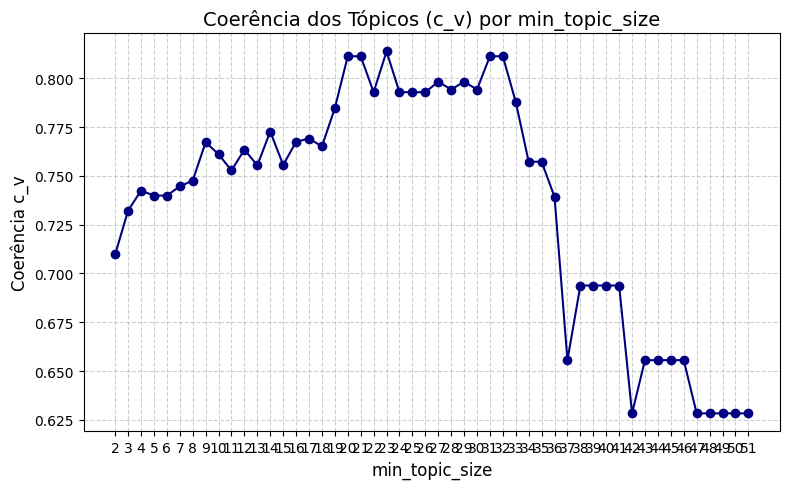

In [40]:
# Gráfico de coerência
plt.figure(figsize=(8, 5))
plt.plot(min_sizes, coerencias, marker='o', linestyle='-', color='navy')
plt.title("Coerência dos Tópicos (c_v) por min_topic_size", fontsize=14)
plt.xlabel("min_topic_size", fontsize=12)
plt.ylabel("Coerência c_v", fontsize=12)
plt.xticks(min_sizes)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("grafico_coerencia_cv.png", dpi=300)
plt.show()


## Tópicos

### Calcula

In [68]:
topic_model = melhor_modelo

# Fit do modelo
topics, probs = topic_model.fit_transform(processed_docs, embeddings)
num_topics = len(topic_model.get_topics())

# Coerência
top_n_words = [[word for word, _ in topic_model.get_topic(topic)]
               for topic in topic_model.get_topics().keys()
               if topic != -1 and topic_model.get_topic(topic)]

cm = CoherenceModel(
     topics=top_n_words,
     texts=tokenized_docs,
     dictionary=dictionary,
     coherence='c_v'
)

# Recuperar informações dos documentos com os tópicos atribuídos
doc_info = topic_model.get_document_info(docs=processed_docs)

# Calcular a proporção de documentos por tópico
topic_counts = doc_info["Topic"].value_counts(normalize=True) * 100

# 2. Ignorar o tópico -1 (outlier), se houver
if -1 in topic_counts:
    topic_counts = topic_counts.drop(-1)

# 3. Cálculo das métricas solicitadas
max_perc = topic_counts.max()
min_perc = topic_counts.min()
desvio_extremos = max_perc - min_perc


coerencia = cm.get_coherence()

# 4. Impressão dos resultados]
print(f"min_topic_size: {melhor_min_topic_size}")
print(f"✅ Quantidade de tópicos encontrados: {num_topics}")
print(f"✅ Coerência encontrada: {coerencia}")
print(f"% do tópico com menos documentos: {min_perc:.2f}%")
print(f"% do tópico com mais documentos: {max_perc:.2f}%")
print(f"Desvio entre extremos: {desvio_extremos:.2f}%")


min_topic_size: 6
✅ Quantidade de tópicos encontrados: 73
✅ Coerência encontrada: 0.7633531226366972
% do tópico com menos documentos: 0.38%
% do tópico com mais documentos: 5.57%
Desvio entre extremos: 5.19%


### Gera Gráficos

In [20]:
# Salvar visualização como HTML
topic_model.visualize_topics()


In [ ]:

topic_model.visualize_barchart(n_words=9)

NameError: name 'melhor_min_topic_size' is not defined

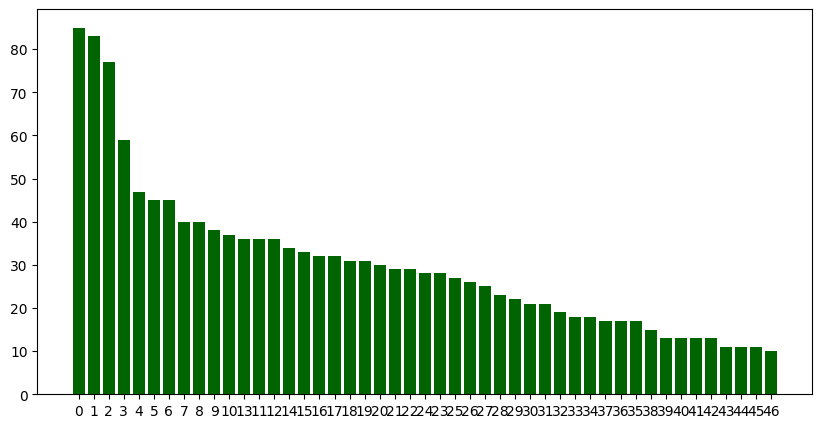

In [21]:
#Gráfico de barras: distribuição dos tópicos do melhor modelo
df_info = topic_model.get_topic_info()
df_info = df_info[df_info.Topic != -1].sort_values("Count", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_info["Topic"].astype(str), df_info["Count"], color='darkgreen')
plt.title(f"Número de Documentos por Tópico (min_topic_size={melhor_min_topic_size})", fontsize=14)
plt.xlabel("Tópico", fontsize=12)
plt.ylabel("Nº de documentos", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("grafico_distribuicao_topicos.png", dpi=300)
plt.show()

### Salva resultados

In [23]:
# Tabela dos tópicos mais representativos
topicos_principais = df_info[["Topic", "Name", "Count"]]
topicos_principais.to_csv("tabela_topicos_mais_representativos.csv", index=False)
print(topicos_principais)

    Topic                                               Name  Count
1       0          0_embargos_declaração_contradição_omissão     85
2       1               1_agravo_execução_petição_liquidação     83
3       2              2_insalubridade_adicional_agente_frio     77
4       3  3_subsidiária_responsabilidade_serviços_admini...     59
5       4                 4_jornada_horas_revezamento_regime     47
6       5  5_honorários_advocatícios_sucumbenciais_sucumb...     45
7       6                 6_inicial_inépcia_pedido_indicação     45
8       7    7_desconsideração_personalidade_jurídica_sócios     40
9       8      8_custas_recursal_admissibilidade_processuais     40
10      9               9_ação_coletiva_individual_executivo     38
11     10          10_substituto_poderes_processual_coletiva     37
14     13                 13_jornada_ponto_cartões_controles     36
12     11        11_agravo_interlocutória_impugnação_petição     36
13     12          12_substituto_poderes_process

In [ ]:
# Salvar todos os dados para reprodutibilidade
df_coerencia = pd.DataFrame({
    "min_topic_size": min_sizes,
    "coerencia_cv": coerencias
})
df_coerencia.to_csv("avaliacao_coerencia_cv.csv", index=False)

In [ ]:
# Recupera os tópicos e as ementas associadas
docs_por_topico = {}
for idx, topic in enumerate(topics):
    if topic == -1:
        continue  # ignora outliers
    if topic not in docs_por_topico:
        docs_por_topico[topic] = []
    docs_por_topico[topic].append(processed_docs[idx])

# Monta a tabela com até 3 ementas por tópico
dados_topicos = []
for topic_id, ementas in docs_por_topico.items():
    termos = [termo for termo, _ in melhor_modelo.get_topic(topic_id)]
    amostras = ementas[:3]  # até 3 ementas por tópico
    dados_topicos.append({
        "Tópico": topic_id,
        "Principais termos": ", ".join(termos),
        "Nº de documentos": len(ementas),
        "Ementa 1": amostras[0] if len(amostras) > 0 else "",
        "Ementa 2": amostras[1] if len(amostras) > 1 else "",
        "Ementa 3": amostras[2] if len(amostras) > 2 else "",
    })

# Cria e salva a tabela
df_topicos = pd.DataFrame(dados_topicos).sort_values("Nº de documentos", ascending=False)
df_topicos.to_csv("topicos_com_ementas.csv", index=False)

print("✅ Tabela gerada: topicos_com_ementas.csv")
df_topicos

✅ Tabela gerada: topicos_com_ementas.csv


,Tópico,Principais termos,Nº de documentos,Ementa 1,Ementa 2,Ementa 3
3,0,"subsidiária, responsabilidade, serviços, fisca...",46,responsabilidade subsidiária ente administraçã...,responsabilidade subsidiária empreitada serviç...,contrato gestão gerenciamento administração ho...
2,1,"custas, recursal, admissibilidade, processuais...",45,recurso ordinário inepto causa pedir ausência ...,agravo instrumento recurso ordinário réu ausên...,agravo instrumento agravo petição intempestivo...
7,2,"inicial, inépcia, pedido, indicação, pedir, pe...",43,eficácia preclusiva coisa julgada ocorrência t...,ação rescisória nulidade citação violação lite...,recurso arguição nulidade julgamentoextra peti...
61,3,"jornada, ponto, cartões, extras, ônus, control...",41,recurso reclamada intervalo intrajornada incon...,jornada cartões ponto validade teor estabelece...,recurso salário comissão base cálculo nulidade...
6,4,"desconsideração, personalidade, sócios, jurídi...",39,agravo petição empresa recuperação judicial ce...,agravo petição execução desconsideração person...,redirecionamento execução face responsável sub...
...,...,...,...,...,...,...
40,90,"adct, parcelamento, débito, rpv, pequeno, valo...",6,execução provisória liberação valores inaplica...,agravo petição requisição pequeno valor precat...,parcelamento débito inaplicabilidade cumprimen...
92,91,"fases, legitimo, difusos, ajuizar, abrangência...",6,agravo petição sindicato substituto processual...,agravo petição sindicato substituto processual...,agravo petição sindicato substituto processual...
94,92,"pje, físico, eletrônico, migração, unidade, pr...",6,agravo instrumento agravo petição interposto p...,agravo instrumento agravo petição interposto p...,agravo instrumento agravo petição interposto p...
4,93,"exclusiva, vítima, culpa, civil, responsabilid...",5,acidente culpa exclusiva vítima responsabilida...,responsabilidade civil empregador acidente mot...,responsabilidade civil acidente culpa exclusiv...
